In [1]:
# %% Cell 1: Enhanced Imports and Configuration
"""
Machine Learning Optimization for SRK/T Formula in FacoDMEK Eyes
Required packages: pip install pandas numpy matplotlib seaborn scikit-learn scipy openpyxl scikit-optimize
"""

# Standard library imports
import json
import warnings
from datetime import datetime
from pathlib import Path

# Data manipulation and numerical computing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score, 
    GridSearchCV, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.base import clone

# Optimization
from scipy.optimize import minimize, differential_evolution, dual_annealing
from scipy import stats

# Bayesian optimization
try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer
    SKOPT_AVAILABLE = True
except ImportError:
    print("Warning: scikit-optimize not installed. Install with: pip install scikit-optimize")
    SKOPT_AVAILABLE = False

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# Global configuration
class Config:
    RANDOM_SEEDS = [42, 123, 456, 789, 2024]  # Multiple seeds for analysis
    CURRENT_SEED = 42  # Default seed for single runs
    TEST_SIZE = 0.30  # 30% test set
    CV_FOLDS = 3      # Cross-validation folds
    N_BOOTSTRAP = 1000  # Bootstrap iterations
    
    # File paths
    DATA_FILE = 'FacoDMEK.xlsx'
    OUTPUT_DIR = Path('output')
    
    # Plotting
    FIGURE_DPI = 100
    FIGURE_SIZE = (10, 6)

# Create output directory
Config.OUTPUT_DIR.mkdir(exist_ok=True)

# Store results for multi-seed analysis
all_seed_results = []
current_seed_results = {}

print("Enhanced ML Pipeline for FacoDMEK IOL Calculations")
print("=" * 60)
print(f"Random Seeds for multi-run analysis: {Config.RANDOM_SEEDS}")
print(f"Current seed: {Config.CURRENT_SEED}")
print(f"Test Set Size: {Config.TEST_SIZE * 100:.0f}%")
print(f"Cross-validation Folds: {Config.CV_FOLDS}")
print(f"Output Directory: {Config.OUTPUT_DIR}")
print("=" * 60)

Enhanced ML Pipeline for FacoDMEK IOL Calculations
Random Seeds for multi-run analysis: [42, 123, 456, 789, 2024]
Current seed: 42
Test Set Size: 30%
Cross-validation Folds: 3
Output Directory: output


In [2]:
# %% Cell 2: Data Loading and Advanced Feature Engineering
"""Load data and create clinically meaningful features"""

class DataProcessor:
    """Handle data loading and feature engineering"""
    
    @staticmethod
    def load_data(filepath):
        """Load and validate data"""
        try:
            df = pd.read_excel(filepath, sheet_name='Data')
            print(f"✓ Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
            return df
        except Exception as e:
            raise ValueError(f"Error loading data: {e}")
    
    @staticmethod
    def create_features(df):
        """Create derived features based on clinical knowledge"""
        df = df.copy()
        
        # Basic derived features
        df['K_avg_Kerato'] = (df['Keratometric Ks'] + df['Keratometric Kf']) / 2
        df['K_Astigmatism_Kerato'] = df['Keratometric Ks'] - df['Keratometric Kf']
        df['K_Cylinder'] = np.abs(df['K_Astigmatism_Kerato'])
        
        # Ratios and relationships
        df['Post_Ant_Ratio'] = df['Posterior Km'] / df['Anterior Km']
        df['AL_K_Ratio'] = df['Bio-AL'] / df['K_avg_Kerato']
        
        # Advanced features
        df['K_Spherical_Equivalent'] = df['K_avg_Kerato'] + 0.5 * df['K_Cylinder']
        
        # Categorize axial length
        df['AL_Category'] = pd.cut(
            df['Bio-AL'], 
            bins=[0, 22, 24.5, 26, 100], 
            labels=['short', 'normal', 'long', 'very_long']
        )
        
        # Additional clinical features if available
        if 'Bio-ACD' in df.columns and 'Bio-LT' in df.columns:
            df['Anterior_Segment_Depth'] = df['Bio-ACD'] + 0.5 * df['Bio-LT']
            if 'Bio-AL' in df.columns:
                df['LP_Factor'] = df['Bio-ACD'] / (df['Bio-AL'] - df['Bio-LT'])
        
        # CCT categories if available
        if 'CCT' in df.columns:
            df['CCT_Category'] = pd.cut(
                df['CCT'],
                bins=[0, 500, 550, 600, 1000],
                labels=['thin', 'normal', 'thick', 'very_thick']
            )
            df['CCT_K_Interaction'] = df['CCT'] * df['K_avg_Kerato'] / 1000
        
        return df
    
    @staticmethod
    def get_feature_summary(df):
        """Print feature summary statistics"""
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        print("\nFeature Summary:")
        print("-" * 60)
        for col in ['Bio-AL', 'K_avg_Kerato', 'CCT', 'IOL Power']:
            if col in df.columns:
                print(f"{col:20s}: μ={df[col].mean():.2f}, σ={df[col].std():.2f}, "
                      f"range=[{df[col].min():.1f}, {df[col].max():.1f}]")

# Load and process data
processor = DataProcessor()
df = processor.load_data(Config.DATA_FILE)
df = processor.create_features(df)
processor.get_feature_summary(df)

print(f"\n✓ Feature engineering completed: {len(df.columns)} total features")

# Store original dataframe for multi-seed analysis
df_original = df.copy()

✓ Data loaded successfully: 96 rows, 29 columns

Feature Summary:
------------------------------------------------------------
Bio-AL              : μ=23.79, σ=1.33, range=[21.2, 28.2]
K_avg_Kerato        : μ=43.63, σ=1.86, range=[39.0, 47.3]
CCT                 : μ=622.36, σ=77.80, range=[505.0, 880.0]
IOL Power           : μ=21.52, σ=4.11, range=[11.0, 30.0]

✓ Feature engineering completed: 40 total features


In [3]:
# %% Cell 3: Advanced Train/Test Split with Validation
"""Create train/test split with proper stratification and validation"""

class DataSplitter:
    """Handle data splitting with validation"""
    
    def __init__(self, test_size=0.3, random_state=42):
        self.test_size = test_size
        self.random_state = random_state
        self.required_cols = [
            'Bio-AL', 'K_avg_Kerato', 'IOL Power', 
            'PostOP Spherical Equivalent', 'A-Constant'
        ]
    
    def split_data(self, df):
        """Create train/test split with stratification"""
        # Filter complete cases
        df_complete = df[df[self.required_cols].notna().all(axis=1)].copy()
        
        print(f"Complete cases: {len(df_complete)} / {len(df)} ({len(df_complete)/len(df)*100:.1f}%)")
        
        # Stratified split by AL category
        df_train, df_test = train_test_split(
            df_complete,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=df_complete['AL_Category']
        )
        
        return df_train, df_test
    
    def validate_split(self, df_train, df_test):
        """Validate the data split"""
        print("\nData Split Validation:")
        print("-" * 40)
        print(f"Training set: {len(df_train)} eyes ({len(df_train)/(len(df_train)+len(df_test))*100:.1f}%)")
        print(f"Test set: {len(df_test)} eyes ({len(df_test)/(len(df_train)+len(df_test))*100:.1f}%)")
        
        # Check distributions
        print("\nAL Distribution:")
        for name, data in [("Train", df_train), ("Test", df_test)]:
            dist = data['AL_Category'].value_counts(normalize=True).sort_index()
            print(f"{name}: " + " | ".join([f"{cat}: {pct*100:.1f}%" for cat, pct in dist.items()]))
        
        # Statistical tests for distribution similarity
        for col in ['Bio-AL', 'K_avg_Kerato']:
            stat, pval = stats.ks_2samp(df_train[col], df_test[col])
            print(f"\nKS test for {col}: p={pval:.3f} {'✓' if pval > 0.05 else '✗'}")

# Split data with current seed
np.random.seed(Config.CURRENT_SEED)
splitter = DataSplitter(test_size=Config.TEST_SIZE, random_state=Config.CURRENT_SEED)
df_train_val, df_test = splitter.split_data(df)
splitter.validate_split(df_train_val, df_test)

# Store for current analysis
current_seed_results['train_size'] = len(df_train_val)
current_seed_results['test_size'] = len(df_test)

Complete cases: 96 / 96 (100.0%)

Data Split Validation:
----------------------------------------
Training set: 67 eyes (69.8%)
Test set: 29 eyes (30.2%)

AL Distribution:
Train: short: 7.5% | normal: 65.7% | long: 17.9% | very_long: 9.0%
Test: short: 6.9% | normal: 65.5% | long: 20.7% | very_long: 6.9%

KS test for Bio-AL: p=0.942 ✓

KS test for K_avg_Kerato: p=0.771 ✓


In [4]:
# %% Cell 4: Optimizable SRK/T Formula Implementation
"""SRK/T formula with optimizable constants for FacoDMEK eyes"""

import scipy.optimize as opt

class OptimizableSRKT:
    """SRK/T formula with learnable constants"""
    
    # Fixed constants
    NA = 1.336  # Aqueous/vitreous refractive index
    
    def __init__(self):
        # Standard SRK/T constants as starting points
        self.default_constants = {
            'keratometer_index': 337.5,      # For corneal radius calculation
            'al_threshold': 24.2,            # AL correction threshold
            'lcor_a': -3.446,               # AL correction coefficients
            'lcor_b': 1.716,
            'lcor_c': -0.0237,
            'cw_a': -5.41,                  # Corneal width coefficients
            'cw_b': 0.58412,
            'cw_c': 0.098,
            'acd_a': 0.62467,               # ACD constant coefficients
            'acd_b': -68.747,
            'offset': -3.336,               # ACD offset
            'ret_a': 0.65696,               # Retinal thickness coefficients
            'ret_b': -0.02029,
            'nc': 1.333,                    # Corneal refractive index
            'multiplier': 1000              # Final calculation multiplier
        }
        
        # Initialize with default values
        self.constants = self.default_constants.copy()
        
    def calculate(self, AL, K, A_const, constants_dict=None):
        """Calculate IOL power with given or current constants"""
        
        # Use provided constants or current ones
        c = constants_dict if constants_dict else self.constants
        
        # Input validation
        if any(pd.isna([AL, K, A_const])) or K <= 0 or AL <= 0:
            return np.nan
        
        try:
            # 1. Corneal radius
            r = c['keratometer_index'] / K
            
            # 2. Axial length correction
            if AL > c['al_threshold']:
                LCOR = c['lcor_a'] + c['lcor_b'] * AL + c['lcor_c'] * AL**2
            else:
                LCOR = AL
            
            # 3. Corneal width
            Cw = c['cw_a'] + c['cw_b'] * LCOR + c['cw_c'] * K
            
            # 4. Corneal height
            discriminant = r**2 - (Cw**2 / 4)
            if discriminant < 0:
                return np.nan
            H = r - np.sqrt(discriminant)
            
            # 5. ACD estimation
            ACDconst = c['acd_a'] * A_const + c['acd_b']
            ACDest = H + ACDconst + c['offset']
            
            # 6. Retinal thickness
            RETHICK = c['ret_a'] + c['ret_b'] * AL
            LOPT = AL + RETHICK
            
            # 7. IOL power calculation
            ncm1 = c['nc'] - 1
            numerator = c['multiplier'] * self.NA * (self.NA * r - ncm1 * LOPT)
            denominator = (LOPT - ACDest) * (self.NA * r - ncm1 * ACDest)
            
            if denominator == 0:
                return np.nan
                
            IOL = numerator / denominator
            
            # Sanity check
            if not (-10 < IOL < 40):
                return np.nan
                
            return IOL
            
        except Exception:
            return np.nan
    
    def calculate_error(self, row, constants_dict=None):
        """Calculate prediction error for a single case"""
        iol_pred = self.calculate(
            row['Bio-AL'], 
            row['K_avg_Kerato'], 
            row['A-Constant'],
            constants_dict
        )
        
        if pd.isna(iol_pred):
            return np.nan
        
        expected_se = -(row['IOL Power'] - iol_pred)
        error = row['PostOP Spherical Equivalent'] - expected_se
        
        return error
    
    def objective_function(self, constants_array, param_names, df_train):
        """Objective function for optimization (minimize MAE)"""
        
        # Convert array to dictionary
        constants_dict = self.constants.copy()
        for i, param in enumerate(param_names):
            constants_dict[param] = constants_array[i]
        
        # Calculate errors for all training cases
        errors = df_train.apply(
            lambda row: self.calculate_error(row, constants_dict),
            axis=1
        )
        
        # Return MAE (excluding NaN values)
        valid_errors = errors.dropna()
        if len(valid_errors) == 0:
            return 1e6  # Penalty for invalid constants
        
        return valid_errors.abs().mean()
    
    def optimize_constants(self, df_train, constants_to_optimize=None, method='differential_evolution'):
        """
        Optimize selected constants using scipy optimization
        PRESERVES SIGN: Negative constants stay negative, positive stay positive
        """
        
        if constants_to_optimize is None:
            # Default: optimize the most impactful constants
            constants_to_optimize = [
                'nc',          # Corneal refractive index
                'cw_a',        # Corneal width intercept
                'cw_b',        # Corneal width AL coefficient
                'cw_c',        # Corneal width K coefficient
                'offset',      # ACD offset
                'ret_a',       # Retinal thickness intercept
                'ret_b'        # Retinal thickness AL coefficient
            ]
        
        print(f"\nOptimizing {len(constants_to_optimize)} constants:")
        for const in constants_to_optimize:
            print(f"  - {const}: {self.constants[const]:.5f} (initial)")
        
        # Set up bounds for each parameter
        bounds = []
        initial_values = []
        
        for param in constants_to_optimize:
            val = self.constants[param]
            
            # Set reasonable bounds that PRESERVE THE SIGN
            if param == 'nc':
                # nc is always positive (refractive index)
                bounds.append((1.325, 1.340))
                
            elif param == 'al_threshold':
                # AL threshold is positive
                bounds.append((23.0, 25.5))
                
            elif param == 'keratometer_index':
                # Always positive
                bounds.append((335.0, 340.0))
                
            elif param == 'multiplier':
                # Always positive, near 1000
                bounds.append((950, 1050))
                
            else:
                # For all other constants, preserve their original sign
                if val < 0:
                    # For NEGATIVE constants
                    # Allow 30% variation but keep negative
                    # val * 1.3 is MORE negative (smaller number)
                    # val * 0.7 is LESS negative (larger number, closer to 0)
                    lower_bound = val * 1.3  # More negative
                    upper_bound = val * 0.7  # Less negative
                    # Ensure lower < upper
                    bounds.append((min(lower_bound, upper_bound), max(lower_bound, upper_bound)))
                else:
                    # For POSITIVE constants
                    # Allow 30% variation but keep positive
                    lower_bound = val * 0.7  # Smaller but positive
                    upper_bound = val * 1.3  # Larger
                    bounds.append((lower_bound, upper_bound))
            
            initial_values.append(val)
        
        # Print bounds for verification
        print("\nParameter bounds (preserving original signs):")
        for i, (param, bound) in enumerate(zip(constants_to_optimize, bounds)):
            original = self.constants[param]
            print(f"  {param}: {original:.5f} → [{bound[0]:.5f}, {bound[1]:.5f}]")
            
            # Verify bounds are correct
            assert bound[0] < bound[1], f"Lower bound must be less than upper bound for {param}"
            
            # Verify sign preservation
            if original < 0:
                assert bound[1] <= 0, f"{param} should stay negative!"
            elif original > 0:
                assert bound[0] >= 0, f"{param} should stay positive!"
        
        # Optimization
        if method == 'differential_evolution':
            print("\nUsing Differential Evolution (global optimization)...")
            result = opt.differential_evolution(
                self.objective_function,
                bounds,
                args=(constants_to_optimize, df_train),
                maxiter=100,
                popsize=15,
                tol=0.0001,
                seed=42,
                disp=True
            )
        
        elif method == 'basinhopping':
            print("\nUsing Basin-hopping (global optimization)...")
            result = opt.basinhopping(
                self.objective_function,
                initial_values,
                minimizer_kwargs={
                    'method': 'L-BFGS-B',
                    'args': (constants_to_optimize, df_train),
                    'bounds': bounds
                },
                niter=100,
                seed=42
            )
        
        else:  # method == 'minimize'
            print("\nUsing L-BFGS-B (local optimization)...")
            result = opt.minimize(
                self.objective_function,
                initial_values,
                args=(constants_to_optimize, df_train),
                method='L-BFGS-B',
                bounds=bounds,
                options={'maxiter': 1000}
            )
        
        # Update constants with optimized values
        print(f"\nOptimization complete! Success: {result.success}")
        print(f"Final MAE: {result.fun:.4f} D")
        print("\nOptimized constants:")
        
        for i, param in enumerate(constants_to_optimize):
            old_val = self.constants[param]
            new_val = result.x[i]
            self.constants[param] = new_val
            change = (new_val - old_val) / abs(old_val) * 100 if old_val != 0 else 0
            print(f"  {param}: {old_val:.5f} → {new_val:.5f} ({change:+.1f}%)")
            
            # Verify sign was preserved
            if old_val < 0:
                assert new_val < 0, f"{param} changed sign!"
            elif old_val > 0:
                assert new_val > 0, f"{param} changed sign!"
        
        return result

# Initialize and test
print("Creating Optimizable SRK/T Formula...")
opt_srkt = OptimizableSRKT()

# Calculate baseline with standard constants
df_train_val['SRKT_Baseline'] = df_train_val.apply(
    lambda row: opt_srkt.calculate(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant']),
    axis=1
)

df_train_val['SRKT_Error_Baseline'] = df_train_val.apply(
    lambda row: opt_srkt.calculate_error(row),
    axis=1
)

baseline_mae = df_train_val['SRKT_Error_Baseline'].abs().mean()
print(f"\nBaseline MAE (standard SRK/T): {baseline_mae:.3f} D")

Creating Optimizable SRK/T Formula...

Baseline MAE (standard SRK/T): 1.551 D


In [5]:
# %% Cell 5: Optimize SRK/T Constants for FacoDMEK
"""Find optimal SRK/T constants using machine learning optimization"""

# Prepare training data
df_opt_train = df_train_val[df_train_val['SRKT_Error_Baseline'].notna()].copy()
print(f"Training on {len(df_opt_train)} complete cases")

# Choose which constants to optimize
OPTIMIZATION_LEVELS = {
    'conservative': ['nc', 'offset'],  # Just 2 parameters
    'moderate': ['nc', 'cw_a', 'cw_b', 'cw_c', 'offset'],  # 5 parameters
    'aggressive': ['nc', 'cw_a', 'cw_b', 'cw_c', 'offset', 'ret_a', 'ret_b', 'acd_a', 'acd_b'],  # 9 parameters
    'comprehensive': ['nc', 'lcor_a', 'lcor_b', 'lcor_c', 'cw_a', 'cw_b', 'cw_c', 
                     'offset', 'ret_a', 'ret_b', 'acd_a', 'acd_b']  # 12 parameters
}

# Select optimization level
optimization_level = 'moderate'  # You can change this
constants_to_optimize = OPTIMIZATION_LEVELS[optimization_level]

print(f"\nOptimization level: {optimization_level}")
print("="*60)

# Optimize constants using differential evolution (global optimization)
result = opt_srkt.optimize_constants(
    df_opt_train,
    constants_to_optimize=constants_to_optimize,
    method='differential_evolution'  # Best for finding global optimum
)

# Calculate performance with optimized constants
df_opt_train['SRKT_Optimized'] = df_opt_train.apply(
    lambda row: opt_srkt.calculate(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant']),
    axis=1
)

df_opt_train['SRKT_Error_Optimized'] = df_opt_train.apply(
    lambda row: opt_srkt.calculate_error(row),
    axis=1
)

# Performance summary
optimized_mae = df_opt_train['SRKT_Error_Optimized'].abs().mean()
optimized_std = df_opt_train['SRKT_Error_Optimized'].abs().std()
improvement = (baseline_mae - optimized_mae) / baseline_mae * 100

print(f"\nTraining Set Performance Summary:")
print(f"  Standard SRK/T MAE: {baseline_mae:.3f} D")
print(f"  Optimized Formula MAE: {optimized_mae:.3f} D")
print(f"  Improvement: {improvement:.1f}%")
print(f"  SD of absolute error: {optimized_std:.3f} D")

# Within target analysis
abs_errors = df_opt_train['SRKT_Error_Optimized'].abs()
within_025 = (abs_errors <= 0.25).mean() * 100
within_050 = (abs_errors <= 0.50).mean() * 100
within_100 = (abs_errors <= 1.00).mean() * 100

print(f"\nClinical Accuracy (Training):")
print(f"  Within ±0.25 D: {within_025:.1f}%")
print(f"  Within ±0.50 D: {within_050:.1f}%")
print(f"  Within ±1.00 D: {within_100:.1f}%")

# Save the optimized formula
model_info = {
    'formula': opt_srkt,
    'formula_constants': opt_srkt.constants.copy(),
    'optimization_level': optimization_level,
    'constants_optimized': constants_to_optimize,
    'baseline_mae': baseline_mae,
    'optimized_mae': optimized_mae,
    'random_seed': Config.CURRENT_SEED
}

# Export the new formula
def FacoDMEK_IOL_Formula(AL, K, A_const):
    """
    Optimized IOL formula for FacoDMEK eyes
    Based on SRK/T with ML-optimized constants
    """
    return opt_srkt.calculate(AL, K, A_const)

print("\n✓ FacoDMEK IOL Formula created successfully!")
print("\nOptimized Formula Constants:")
print("-" * 60)
for param in constants_to_optimize:
    original = opt_srkt.default_constants[param]
    optimized = opt_srkt.constants[param]
    change = (optimized - original) / abs(original) * 100
    print(f"{param:15s}: {original:8.5f} → {optimized:8.5f} ({change:+6.1f}%)")

Training on 67 complete cases

Optimization level: moderate

Optimizing 5 constants:
  - nc: 1.33300 (initial)
  - cw_a: -5.41000 (initial)
  - cw_b: 0.58412 (initial)
  - cw_c: 0.09800 (initial)
  - offset: -3.33600 (initial)

Parameter bounds (preserving original signs):
  nc: 1.33300 → [1.32500, 1.34000]
  cw_a: -5.41000 → [-7.03300, -3.78700]
  cw_b: 0.58412 → [0.40888, 0.75936]
  cw_c: 0.09800 → [0.06860, 0.12740]
  offset: -3.33600 → [-4.33680, -2.33520]

Using Differential Evolution (global optimization)...
differential_evolution step 1: f(x)= 1.0660359199742968
differential_evolution step 2: f(x)= 1.0660359199742968
differential_evolution step 3: f(x)= 1.0660359199742968
differential_evolution step 4: f(x)= 1.0660359199742968
differential_evolution step 5: f(x)= 1.0381208235093942
differential_evolution step 6: f(x)= 1.0381208235093942
differential_evolution step 7: f(x)= 1.0381208235093942
differential_evolution step 8: f(x)= 1.0381208235093942
differential_evolution step 9: f


Evaluating on test set...

Test Set Results:
------------------------------------------------------------
Metric               Standard SRK/T  Optimized Formula
------------------------------------------------------------
MAE (D)              1.319           1.279          
Median AE (D)        0.913           1.119          
SD (D)               1.289           1.186          
RMSE (D)             1.829           1.726          
Within ±0.25 D (%)   17.2            8.7            
Within ±0.50 D (%)   31.0            30.4           
Within ±1.00 D (%)   55.2            47.8           

Improvement: 3.1%

Paired t-test: p = 0.8122
Significant improvement: No


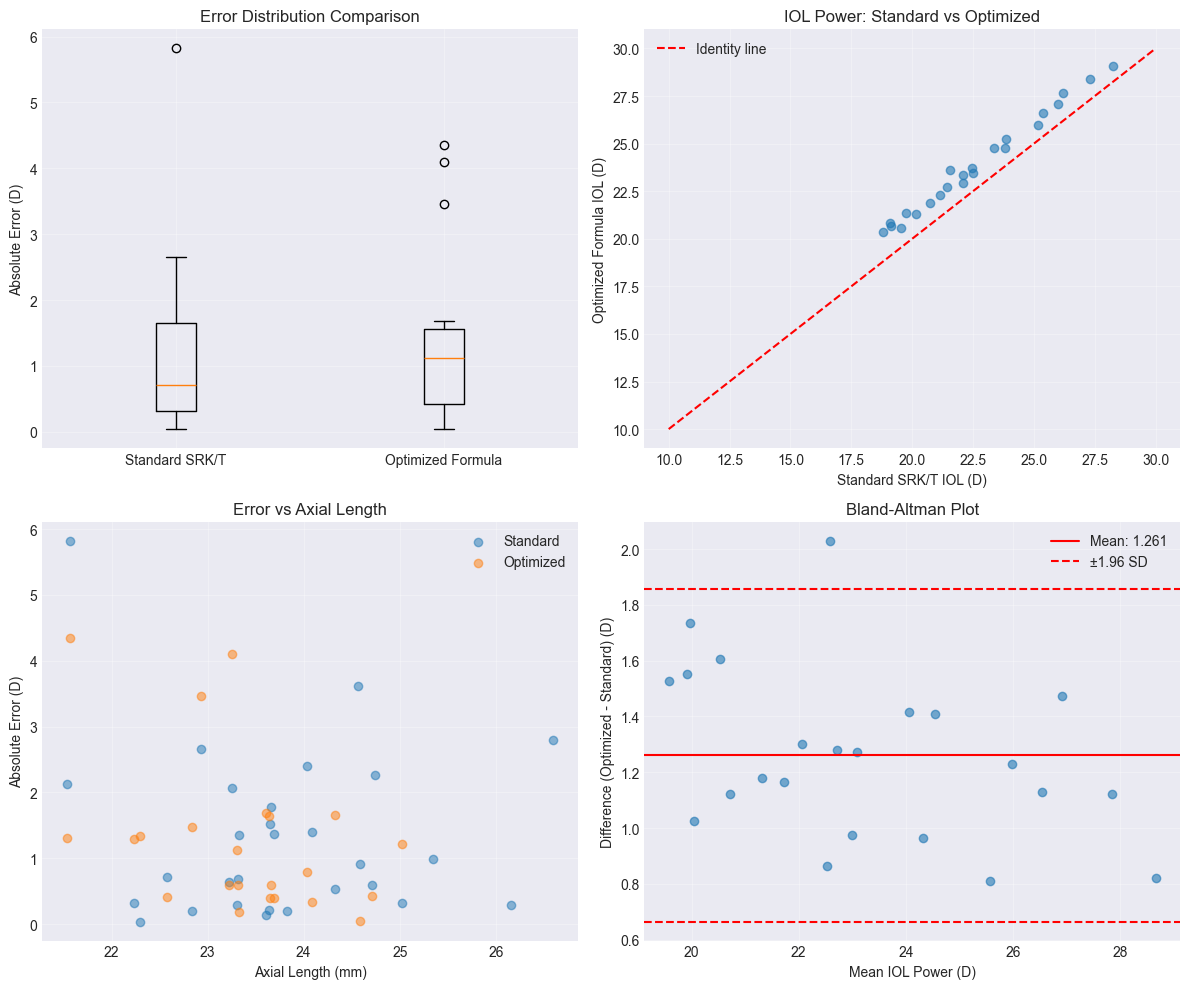


FACODMEK IOL FORMULA (OPTIMIZED)

Formula structure: Same as SRK/T
Optimized constants:
  cw_a: -4.84301 (was -5.41000)
  cw_b: 0.68289 (was 0.58412)
  cw_c: 0.06896 (was 0.09800)
  offset: -3.49152 (was -3.33600)
  nc: 1.33999 (was 1.33300)

✓ Formula saved to: output\facodmek_formula_seed42.csv

✓ Analysis complete!


In [6]:
# %% Cell 7: Test Set Evaluation - Optimized Formula Only
"""Evaluate the optimized formula on held-out test set"""

print("\nEvaluating on test set...")
print("=" * 60)

# Standard SRK/T calculator for comparison
class SRKTCalculator:
    """Standard SRK/T for comparison"""
    NA = 1.336
    
    @staticmethod
    def calculate(AL, K, A_const, nc=1.333):
        """Standard SRK/T calculation"""
        if any(pd.isna([AL, K, A_const])) or K <= 0 or AL <= 0:
            return np.nan
        
        try:
            r = 337.5 / K
            
            if AL > 24.2:
                LCOR = -3.446 + 1.716 * AL - 0.0237 * AL**2
            else:
                LCOR = AL
            
            Cw = -5.41 + 0.58412 * LCOR + 0.098 * K
            
            discriminant = r**2 - (Cw**2 / 4)
            if discriminant < 0:
                return np.nan
            H = r - np.sqrt(discriminant)
            
            ACDconst = 0.62467 * A_const - 68.747
            offset = ACDconst - 3.336
            ACDest = H + offset
            
            RETHICK = 0.65696 - 0.02029 * AL
            LOPT = AL + RETHICK
            
            ncm1 = nc - 1
            numerator = 1000 * SRKTCalculator.NA * (SRKTCalculator.NA * r - ncm1 * LOPT)
            denominator = (LOPT - ACDest) * (SRKTCalculator.NA * r - ncm1 * ACDest)
            
            if denominator == 0:
                return np.nan
                
            IOL = numerator / denominator
            
            if not (-10 < IOL < 40):
                return np.nan
                
            return IOL
            
        except Exception:
            return np.nan
    
    @staticmethod
    def calculate_error(row, nc=1.333):
        """Calculate prediction error"""
        iol_pred = SRKTCalculator.calculate(
            row['Bio-AL'], 
            row['K_avg_Kerato'], 
            row['A-Constant'], 
            nc
        )
        
        if pd.isna(iol_pred):
            return np.nan
        
        expected_se = -(row['IOL Power'] - iol_pred)
        error = row['PostOP Spherical Equivalent'] - expected_se
        
        return error

# Calculate errors with standard SRK/T
df_test['Error_Standard'] = df_test.apply(
    lambda row: SRKTCalculator.calculate_error(row, nc=1.333),
    axis=1
)

# Calculate errors with optimized formula
df_test['Error_Optimized'] = df_test.apply(
    lambda row: opt_srkt.calculate_error(row),
    axis=1
)

# Calculate predictions for analysis
df_test['IOL_Standard'] = df_test.apply(
    lambda row: SRKTCalculator.calculate(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant'], nc=1.333),
    axis=1
)

df_test['IOL_Optimized'] = df_test.apply(
    lambda row: opt_srkt.calculate(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant']),
    axis=1
)

# Performance metrics
def calculate_metrics(errors):
    abs_errors = errors.abs()
    return {
        'n': len(errors),
        'mae': abs_errors.mean(),
        'median_ae': abs_errors.median(),
        'std': abs_errors.std(),
        'rmse': np.sqrt((errors ** 2).mean()),
        'max_error': abs_errors.max(),
        'within_025': (abs_errors <= 0.25).mean() * 100,
        'within_050': (abs_errors <= 0.50).mean() * 100,
        'within_100': (abs_errors <= 1.00).mean() * 100
    }

standard_metrics = calculate_metrics(df_test['Error_Standard'].dropna())
optimized_metrics = calculate_metrics(df_test['Error_Optimized'].dropna())

# Display results
print("\nTest Set Results:")
print("-" * 60)
print(f"{'Metric':<20} {'Standard SRK/T':<15} {'Optimized Formula':<15}")
print("-" * 60)
print(f"{'MAE (D)':<20} {standard_metrics['mae']:<15.3f} {optimized_metrics['mae']:<15.3f}")
print(f"{'Median AE (D)':<20} {standard_metrics['median_ae']:<15.3f} {optimized_metrics['median_ae']:<15.3f}")
print(f"{'SD (D)':<20} {standard_metrics['std']:<15.3f} {optimized_metrics['std']:<15.3f}")
print(f"{'RMSE (D)':<20} {standard_metrics['rmse']:<15.3f} {optimized_metrics['rmse']:<15.3f}")
print(f"{'Within ±0.25 D (%)':<20} {standard_metrics['within_025']:<15.1f} {optimized_metrics['within_025']:<15.1f}")
print(f"{'Within ±0.50 D (%)':<20} {standard_metrics['within_050']:<15.1f} {optimized_metrics['within_050']:<15.1f}")
print(f"{'Within ±1.00 D (%)':<20} {standard_metrics['within_100']:<15.1f} {optimized_metrics['within_100']:<15.1f}")

improvement = (standard_metrics['mae'] - optimized_metrics['mae']) / standard_metrics['mae'] * 100
print(f"\nImprovement: {improvement:.1f}%")

# Statistical significance test
from scipy import stats

# Paired t-test
common_idx = df_test['Error_Standard'].notna() & df_test['Error_Optimized'].notna()
errors_standard = df_test.loc[common_idx, 'Error_Standard'].abs()
errors_optimized = df_test.loc[common_idx, 'Error_Optimized'].abs()

t_stat, p_value = stats.ttest_rel(errors_standard, errors_optimized)
print(f"\nPaired t-test: p = {p_value:.4f}")
print(f"Significant improvement: {'Yes' if p_value < 0.05 else 'No'}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Error distributions
ax = axes[0, 0]
ax.boxplot([errors_standard, errors_optimized], labels=['Standard SRK/T', 'Optimized Formula'])
ax.set_ylabel('Absolute Error (D)')
ax.set_title('Error Distribution Comparison')
ax.grid(True, alpha=0.3)

# 2. Scatter plot: Standard vs Optimized predictions
ax = axes[0, 1]
ax.scatter(df_test['IOL_Standard'], df_test['IOL_Optimized'], alpha=0.6)
ax.plot([10, 30], [10, 30], 'r--', label='Identity line')
ax.set_xlabel('Standard SRK/T IOL (D)')
ax.set_ylabel('Optimized Formula IOL (D)')
ax.set_title('IOL Power: Standard vs Optimized')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Error vs Axial Length
ax = axes[1, 0]
ax.scatter(df_test['Bio-AL'], df_test['Error_Standard'].abs(), alpha=0.5, label='Standard')
ax.scatter(df_test['Bio-AL'], df_test['Error_Optimized'].abs(), alpha=0.5, label='Optimized')
ax.set_xlabel('Axial Length (mm)')
ax.set_ylabel('Absolute Error (D)')
ax.set_title('Error vs Axial Length')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Bland-Altman plot
ax = axes[1, 1]
mean_iol = (df_test['IOL_Standard'] + df_test['IOL_Optimized']) / 2
diff_iol = df_test['IOL_Optimized'] - df_test['IOL_Standard']
ax.scatter(mean_iol, diff_iol, alpha=0.6)
ax.axhline(y=diff_iol.mean(), color='r', linestyle='-', label=f'Mean: {diff_iol.mean():.3f}')
ax.axhline(y=diff_iol.mean() + 1.96*diff_iol.std(), color='r', linestyle='--', label='±1.96 SD')
ax.axhline(y=diff_iol.mean() - 1.96*diff_iol.std(), color='r', linestyle='--')
ax.set_xlabel('Mean IOL Power (D)')
ax.set_ylabel('Difference (Optimized - Standard) (D)')
ax.set_title('Bland-Altman Plot')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / f'formula_evaluation_seed{Config.CURRENT_SEED}.png', dpi=Config.FIGURE_DPI)
plt.show()

# Print final formula
print("\n" + "="*60)
print("FACODMEK IOL FORMULA (OPTIMIZED)")
print("="*60)
print("\nFormula structure: Same as SRK/T")
print("Optimized constants:")
for param, value in opt_srkt.constants.items():
    if param in constants_to_optimize:
        original = opt_srkt.default_constants[param]
        print(f"  {param}: {value:.5f} (was {original:.5f})")

# Save formula constants
constants_df = pd.DataFrame([
    {'parameter': k, 'original': opt_srkt.default_constants[k], 'optimized': v} 
    for k, v in opt_srkt.constants.items()
])
constants_df.to_csv(Config.OUTPUT_DIR / f'facodmek_formula_seed{Config.CURRENT_SEED}.csv', index=False)
print(f"\n✓ Formula saved to: {Config.OUTPUT_DIR / f'facodmek_formula_seed{Config.CURRENT_SEED}.csv'}")

# Store results
current_seed_results.update({
    'test_standard_mae': standard_metrics['mae'],
    'test_optimized_mae': optimized_metrics['mae'],
    'test_final_mae': optimized_metrics['mae'],  # Same as optimized (no ensemble)
    'test_final_within_050': optimized_metrics['within_050'],
    'test_final_within_100': optimized_metrics['within_100'],
    'improvement_percent': improvement,
    'p_value': p_value,
    'seed': Config.CURRENT_SEED
})

# Add to all results
all_seed_results.append(current_seed_results.copy())

print("\n✓ Analysis complete!")

In [7]:
# %% Cell 8: Multi-Seed Analysis Runner
"""Run the complete analysis for multiple seeds"""

# Check if you want to run multi-seed analysis
RUN_MULTI_SEED = True  # Set to True to run analysis for all seeds

if RUN_MULTI_SEED:
    print("\n" + "="*80)
    print("STARTING MULTI-SEED ANALYSIS")
    print("="*80)
    
    # Clear previous results
    all_seed_results = []
    all_formula_constants = {}
    
    for seed_idx, seed in enumerate(Config.RANDOM_SEEDS):
        print(f"\n{'#'*80}")
        print(f"RUNNING SEED {seed_idx + 1}/{len(Config.RANDOM_SEEDS)}: {seed}")
        print(f"{'#'*80}")
        
        # Update current seed
        Config.CURRENT_SEED = seed
        np.random.seed(seed)
        current_seed_results = {'seed': seed}
        
        # 1. Split data
        splitter = DataSplitter(test_size=Config.TEST_SIZE, random_state=seed)
        df_train_val, df_test = splitter.split_data(df_original)
        
        # 2. Create optimizable formula
        opt_srkt = OptimizableSRKT()
        
        # Calculate baseline with standard constants
        df_train_val['SRKT_Baseline'] = df_train_val.apply(
            lambda row: opt_srkt.calculate(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant']),
            axis=1
        )
        df_train_val['SRKT_Error_Baseline'] = df_train_val.apply(
            lambda row: opt_srkt.calculate_error(row),
            axis=1
        )
        
        baseline_mae = df_train_val['SRKT_Error_Baseline'].abs().mean()
        
        # 3. Optimize formula constants
        df_opt_train = df_train_val[df_train_val['SRKT_Error_Baseline'].notna()].copy()
        
        # Choose optimization level
        optimization_level = 'moderate'  # Can be 'conservative', 'moderate', 'aggressive'
        OPTIMIZATION_LEVELS = {
            'conservative': ['nc', 'offset'],
            'moderate': ['nc', 'cw_a', 'cw_b', 'cw_c', 'offset'],
            'aggressive': ['nc', 'cw_a', 'cw_b', 'cw_c', 'offset', 'ret_a', 'ret_b', 'acd_a', 'acd_b']
        }
        constants_to_optimize = OPTIMIZATION_LEVELS[optimization_level]
        
        # Optimize
        result = opt_srkt.optimize_constants(
            df_opt_train,
            constants_to_optimize=constants_to_optimize,
            method='differential_evolution'
        )
        
        # Store optimized constants
        all_formula_constants[seed] = opt_srkt.constants.copy()
        
        # Calculate performance with optimized constants
        df_opt_train['SRKT_Optimized'] = df_opt_train.apply(
            lambda row: opt_srkt.calculate(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant']),
            axis=1
        )
        df_opt_train['SRKT_Error_Optimized'] = df_opt_train.apply(
            lambda row: opt_srkt.calculate_error(row),
            axis=1
        )
        
        optimized_mae = df_opt_train['SRKT_Error_Optimized'].abs().mean()
        
        # 4. Test evaluation
        df_test['Error_Standard'] = df_test.apply(
            lambda row: SRKTCalculator.calculate_error(row, nc=1.333),
            axis=1
        )
        df_test['Error_Optimized'] = df_test.apply(
            lambda row: opt_srkt.calculate_error(row),
            axis=1
        )
        
        # Calculate metrics
        standard_metrics = calculate_metrics(df_test['Error_Standard'].dropna())
        optimized_metrics = calculate_metrics(df_test['Error_Optimized'].dropna())
        
        # Collect results
        current_seed_results.update({
            'optimal_nc': opt_srkt.constants['nc'],
            'train_baseline_mae': baseline_mae,
            'train_optimized_mae': optimized_mae,
            'test_standard_mae': standard_metrics['mae'],
            'test_optimized_mae': optimized_metrics['mae'],
            'test_final_mae': optimized_metrics['mae'],
            'test_final_within_050': optimized_metrics['within_050'],
            'test_final_within_100': optimized_metrics['within_100'],
            'improvement_percent': ((standard_metrics['mae'] - optimized_metrics['mae']) / 
                                  standard_metrics['mae'] * 100)
        })
        
        all_seed_results.append(current_seed_results)
        
        print(f"\nSeed {seed} Results:")
        print(f"  Optimal nc: {opt_srkt.constants['nc']:.5f}")
        print(f"  Test MAE: {current_seed_results['test_optimized_mae']:.3f} D")
        print(f"  Improvement: {current_seed_results['improvement_percent']:.1f}%")
    
    # Convert to DataFrame
    multi_seed_df = pd.DataFrame(all_seed_results)
    
    print("\n" + "="*80)
    print("MULTI-SEED ANALYSIS COMPLETE!")
    print("="*80)
    
    # Summary statistics
    print("\n1. FORMULA CONSTANTS ACROSS SEEDS:")
    print("-" * 60)
    
    # Analyze constant variations
    constant_stats = {}
    for param in constants_to_optimize:
        values = [all_formula_constants[seed][param] for seed in Config.RANDOM_SEEDS]
        constant_stats[param] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values)
        }
        print(f"\n{param}:")
        print(f"  Mean: {constant_stats[param]['mean']:.5f}")
        print(f"  Std:  {constant_stats[param]['std']:.5f}")
        print(f"  Range: [{constant_stats[param]['min']:.5f}, {constant_stats[param]['max']:.5f}]")
    
    print("\n2. TEST SET MAE ACROSS SEEDS:")
    print("-" * 60)
    for method in ['test_standard_mae', 'test_optimized_mae']:
        method_name = method.replace('test_', '').replace('_mae', '').replace('_', ' ').title()
        print(f"\n{method_name}:")
        print(f"  Mean: {multi_seed_df[method].mean():.3f} D")
        print(f"  Std:  {multi_seed_df[method].std():.3f} D")
        print(f"  Range: [{multi_seed_df[method].min():.3f}, {multi_seed_df[method].max():.3f}]")
    
    print("\n3. IMPROVEMENT PERCENTAGE:")
    print("-" * 60)
    print(f"Mean: {multi_seed_df['improvement_percent'].mean():.1f}%")
    print(f"Std:  {multi_seed_df['improvement_percent'].std():.1f}%")
    print(f"Range: [{multi_seed_df['improvement_percent'].min():.1f}%, {multi_seed_df['improvement_percent'].max():.1f}%]")
    
    print("\n4. CLINICAL ACCURACY (Optimized Formula):")
    print("-" * 60)
    print(f"Within ±0.50D: {multi_seed_df['test_final_within_050'].mean():.1f}% (±{multi_seed_df['test_final_within_050'].std():.1f}%)")
    print(f"Within ±1.00D: {multi_seed_df['test_final_within_100'].mean():.1f}% (±{multi_seed_df['test_final_within_100'].std():.1f}%)")
    
    # Save results
    multi_seed_df.to_csv(Config.OUTPUT_DIR / 'multi_seed_results_facodmek.csv', index=False)
    print(f"\n✓ Results saved to: {Config.OUTPUT_DIR / 'multi_seed_results_facodmek.csv'}")
    
    # Save average formula constants
    avg_constants = {}
    for param in opt_srkt.default_constants.keys():
        values = [all_formula_constants[seed][param] for seed in Config.RANDOM_SEEDS]
        avg_constants[param] = np.mean(values)
    
    avg_constants_df = pd.DataFrame([
        {'parameter': k, 'value': v, 'std': constant_stats.get(k, {}).get('std', 0)} 
        for k, v in avg_constants.items()
    ])
    avg_constants_df.to_csv(Config.OUTPUT_DIR / 'facodmek_formula_average_constants.csv', index=False)
    print(f"✓ Average formula constants saved to: {Config.OUTPUT_DIR / 'facodmek_formula_average_constants.csv'}")
    
    # Display full table
    print("\nDETAILED RESULTS BY SEED:")
    print("="*80)
    print(multi_seed_df.to_string(index=False, float_format=lambda x: f'{x:.3f}' if x < 10 else f'{x:.1f}'))
    
else:
    print("\nMulti-seed analysis not run. Set RUN_MULTI_SEED=True in Cell 8 to run it.")


STARTING MULTI-SEED ANALYSIS

################################################################################
RUNNING SEED 1/5: 42
################################################################################
Complete cases: 96 / 96 (100.0%)

Optimizing 5 constants:
  - nc: 1.33300 (initial)
  - cw_a: -5.41000 (initial)
  - cw_b: 0.58412 (initial)
  - cw_c: 0.09800 (initial)
  - offset: -3.33600 (initial)

Parameter bounds (preserving original signs):
  nc: 1.33300 → [1.32500, 1.34000]
  cw_a: -5.41000 → [-7.03300, -3.78700]
  cw_b: 0.58412 → [0.40888, 0.75936]
  cw_c: 0.09800 → [0.06860, 0.12740]
  offset: -3.33600 → [-4.33680, -2.33520]

Using Differential Evolution (global optimization)...
differential_evolution step 1: f(x)= 1.0660359199742968
differential_evolution step 2: f(x)= 1.0660359199742968
differential_evolution step 3: f(x)= 1.0660359199742968
differential_evolution step 4: f(x)= 1.0660359199742968
differential_evolution step 5: f(x)= 1.0381208235093942
differential_